In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

import matplotlib.pyplot as plt
from plotnine import *
from statstools.patchwork import PGrid
theme_set(theme_bw())

In [54]:
mask = pd.read_csv("masking_tape.csv")

## Exploratory Data Analysis

### Number of Seeps

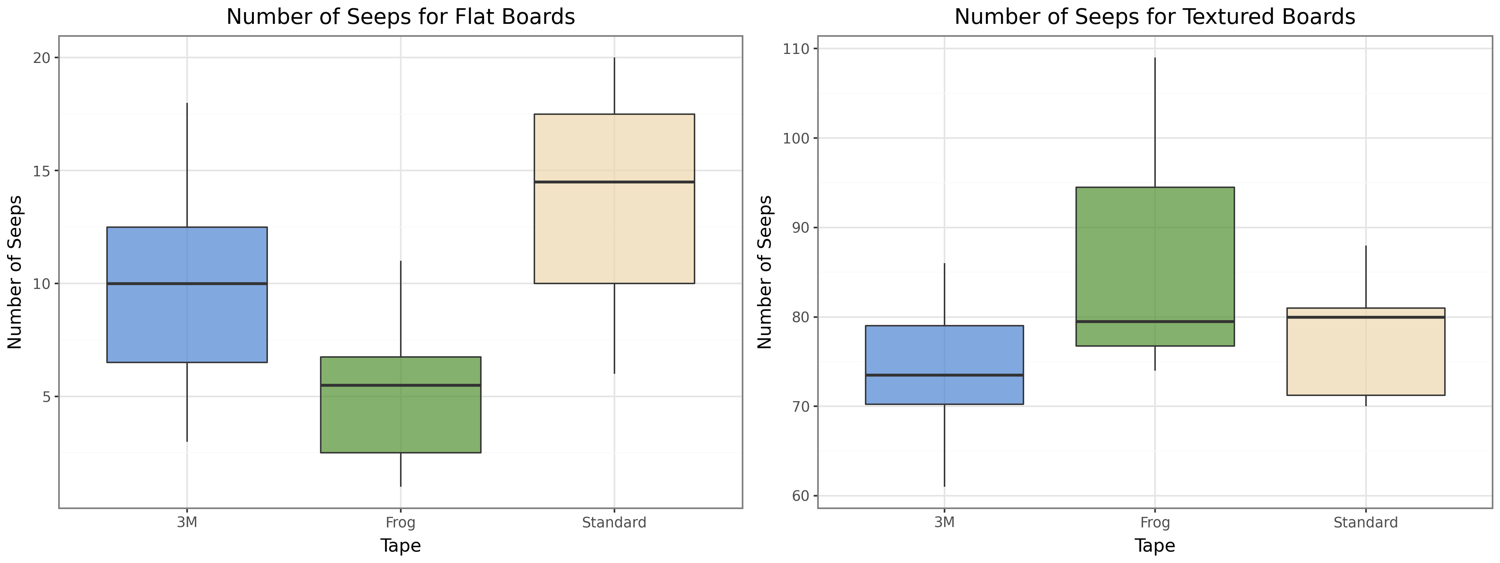

In [18]:
Flat = ggplot(mask[mask["texture"] == "Flat"]) \
+ geom_boxplot(aes(y = 'num_seeps',x = 'tape',fill = 'tape'), alpha = 0.7) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ theme(legend_position="none") \
+ labs(
    title = "Number of Seeps for Flat Boards",
    x = "Tape",
    y = "Number of Seeps"
)
Textured = ggplot(mask[mask["texture"] == "Textured"]) \
+ geom_boxplot(aes(y = 'num_seeps',x = 'tape',fill = 'tape'), alpha = 0.7) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ theme(legend_position="none") \
+ labs(
    title = "Number of Seeps for Textured Boards",
    x = "Tape",
    y = "Number of Seeps"
)

grid = PGrid({"Flat" : Flat,
              "Textured" : Textured})
grid.quilt("Flat + Textured", size = (1500, 2000))

Right off of the bat, it does look like there is a clear difference among the tapes for the flat boards and it looks like the textured boards don't have much of a difference it terms of seepage.

Additionally, it looks like the poisson distribution might be a resonable model for the data, as it seems as though the variance increases as the mean increases

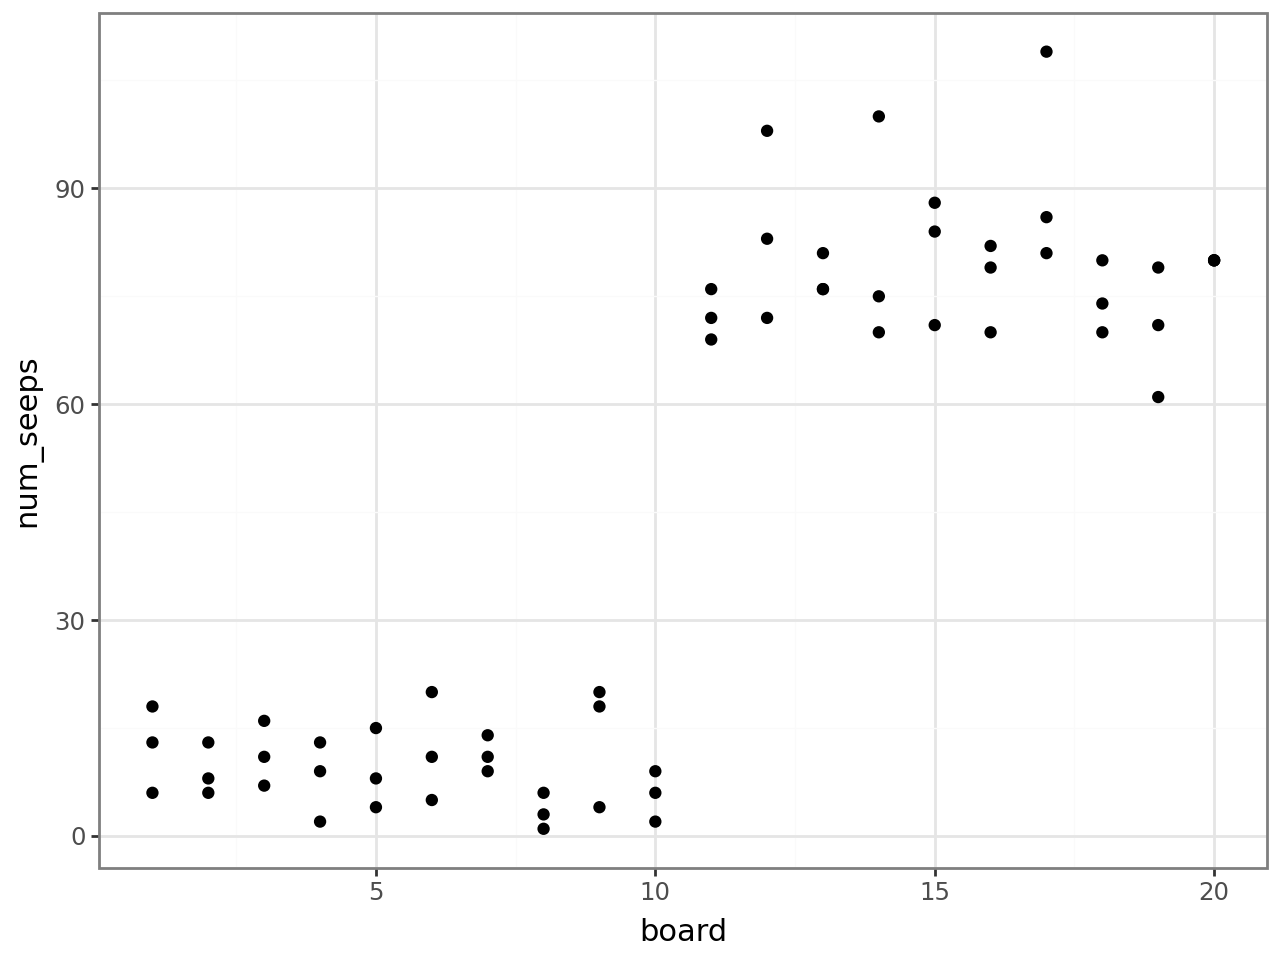

In [19]:
ggplot(mask) \
+ geom_point(aes(x = "board", y = "num_seeps"))

Luckily it doesn't look as though tehre is any sort of linear patter over time as we were counting the number of seeps

# Analysis

In [55]:
# Bookkeeping
mask['board_idx'] = mask['board'].factorize()[0]
mask['texture_idx'] = mask['texture'].factorize()[0]
mask['tape_idx'] = mask['tape'].factorize()[0]

In [56]:
mask \
    [['tape', 'texture', 'num_seeps']] \
    .groupby(['tape', 'texture']) \
    .mean() \
    .reset_index() \
    .assign(log_mean = lambda r: np.log(r['num_seeps']))

,tape,texture,num_seeps,log_mean
0,3M,Flat,9.6,2.261763
1,3M,Textured,74.2,4.306764
2,Frog,Flat,5.2,1.648659
3,Frog,Textured,85.5,4.448516
4,Standard,Flat,14.0,2.639057
5,Standard,Textured,77.6,4.351567


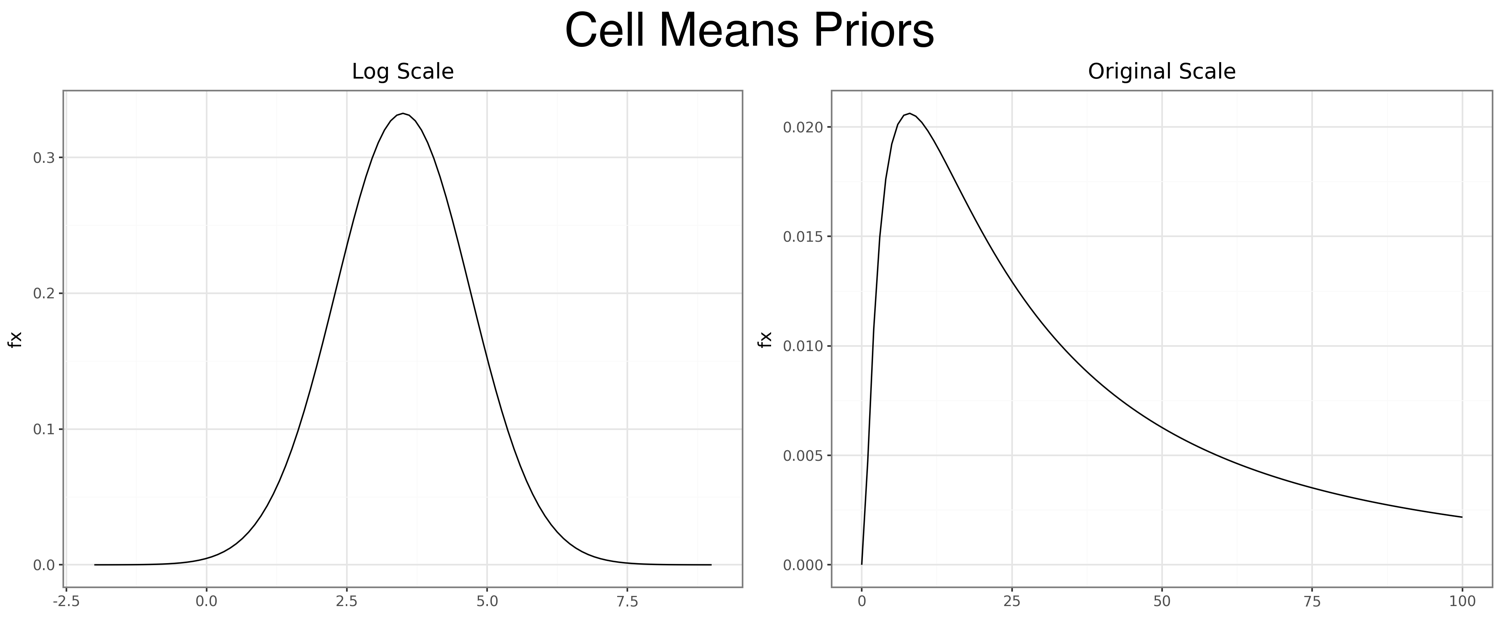

In [35]:
orig = ggplot() \
+ stat_function(fun = stats.lognorm.pdf, args = {"scale" : np.exp(3.5), "s" : 1.2}) \
+ xlim(0, 100) \
+ labs(
    title = "Original Scale"
)

# Investigate different choices of priors
log = ggplot() \
+ stat_function(fun = stats.norm.pdf, args = {"loc" : 3.5, "scale" : 1.2}) \
+ xlim(-2, 9)  \
+ labs(
    title = "Log Scale"
)
PGrid({"orig" : orig, "log" : log}).quilt("log + orig", size = (1500, 2000), title = "Cell Means Priors")

I chose a normal prior with a mean of 3.5 and a standard deviation of 1.2 because this allows for a mean to fall anywhere between 0 and 100 very easily while also being very uninformative. It has more probability towards the front of the distribution, which is good because I would expect to have more counts that are in that range.

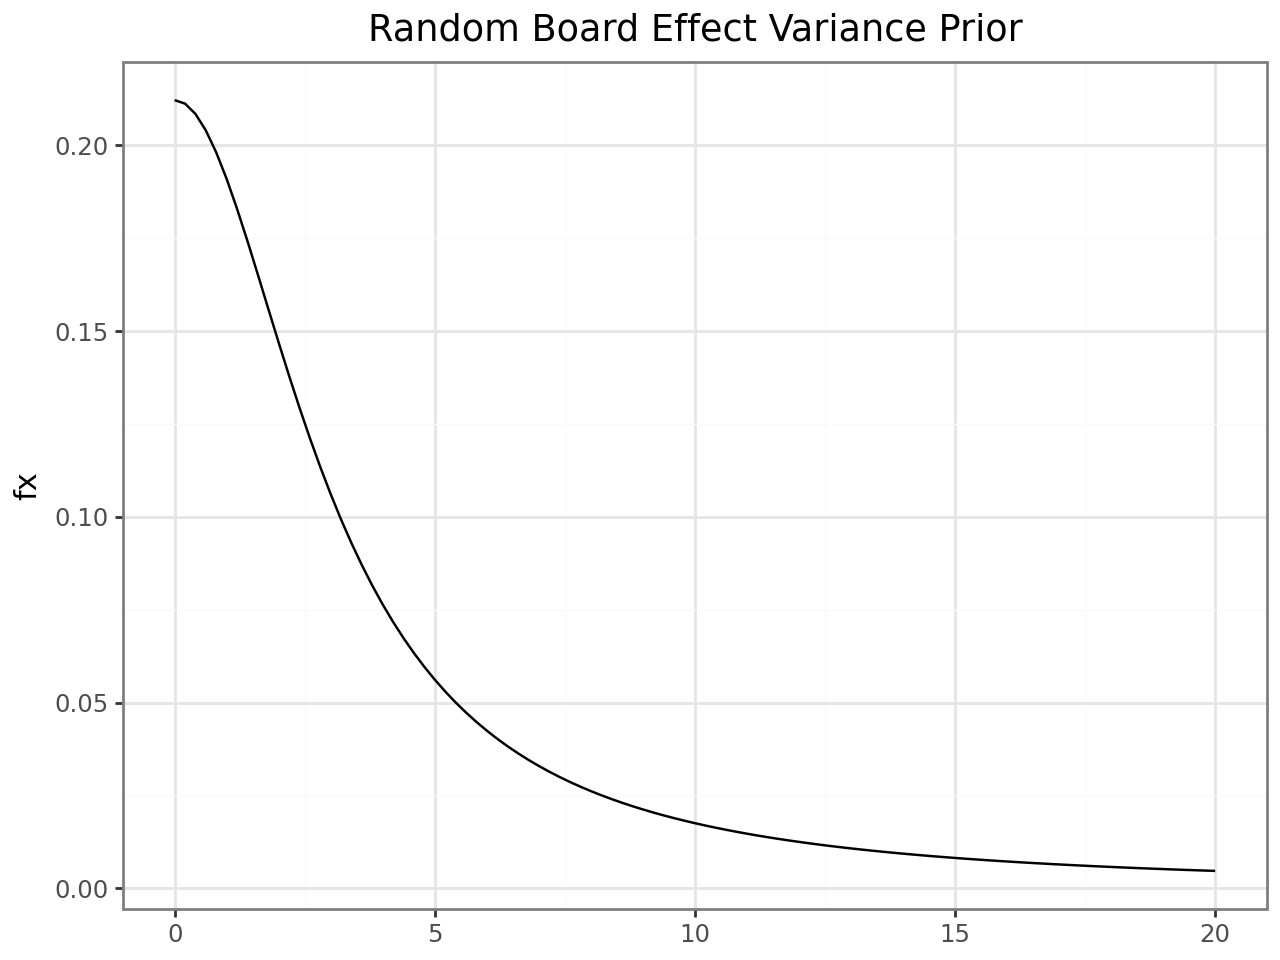

In [32]:
ggplot() \
+ stat_function(fun = stats.halfcauchy.pdf, args = {"scale" : 3}) \
+ xlim(0, 20) \
+ labs(
    title = "Random Board Effect Variance Prior"
)

I choose the Half Cauchy distribution with a beta parameter of 3 because, I expect from previous painting experience that the variance due to the board will be low, but I still want to allow room for the data to pull the variance up as need be.

In [57]:
coords = {
    "tape" : ["Frog", "3M", "Standard"],
    "texture" : ["Flat", "Textured"],
    "board" : np.arange(20),
    "obs_id" : np.arange(mask.shape[0])
}

with pm.Model(coords=coords) as model:
    # Data
    tape_idx = pm.Data("tape_idx", mask['tape_idx'], dims = "obs_id")
    texture_idx = pm.Data("texture_idx", mask['texture_idx'], dims = "obs_id")
    board_idx = pm.Data("board_idx", mask['board_idx'], dims = "obs_id")
    Y_data = pm.Data("Y_data", mask['num_seeps'], dims = "obs_id")
    # Variance Parameters
    sigma_b = pm.HalfCauchy("sigma_b", beta = 3)

    # Fixed Effect Priors
    means = pm.Normal("means", mu = 3.5, sigma = 1.2, dims = ("tape", "texture"))

    # Random Effect Priors
    rand_eff_offset = pm.Normal("board_eff_offset", mu = 0, sigma = 1, dims = "board")
    rand_eff = pm.Deterministic("board_eff", rand_eff_offset * sigma_b)

    # Model Formulation
    lam = pm.math.exp(means[tape_idx, texture_idx] + rand_eff[board_idx])

    y = pm.Poisson("y", mu = lam, observed = Y_data, dims = "obs_id")

In [10]:
with model:
    idata = pm.sample(
        draws=15000,
        tune = 10000,
        progressbar="split",
        target_accept = 0.99
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_b, means, board_eff_offset]


Output()

Sampling 4 chains for 10_000 tune and 15_000 draw iterations (40_000 + 60_000 draws total) took 233 seconds.


In [11]:
# Write out to a file so we don't have to run the model over again
idata.to_netcdf("results.nc")

'results.nc'

In [37]:
idata = az.from_netcdf("results.nc")

## Model Validation

### Convergence and Model Fit

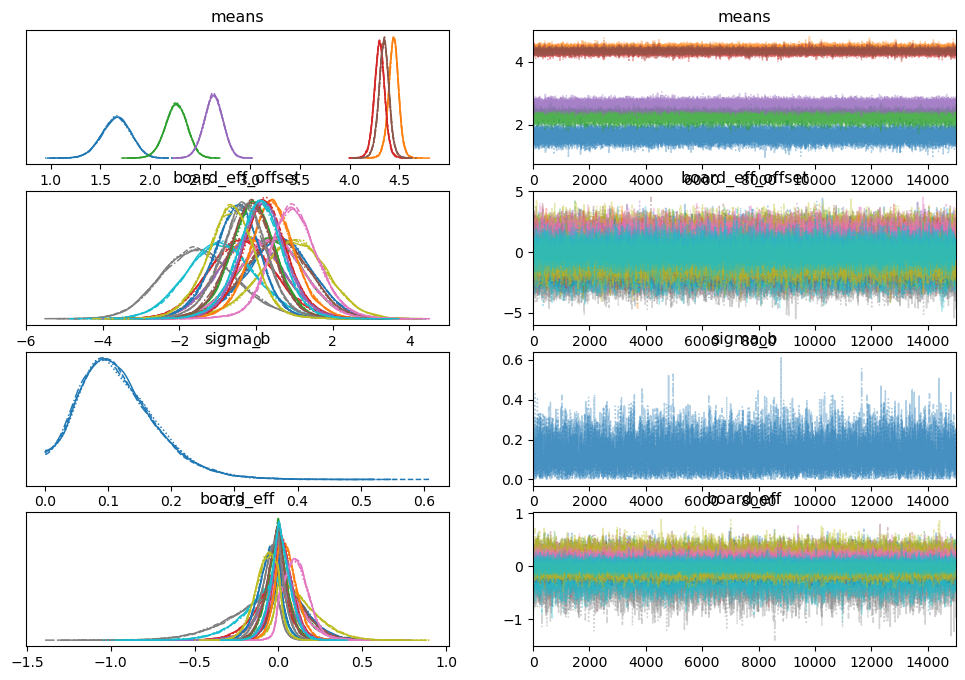

In [12]:
az.plot_trace(idata.posterior)
plt.show()

In [51]:
post_summary = az.summary(idata)
post_summary[["mean", "ess_bulk", "ess_tail", "r_hat"]]

,mean,ess_bulk,ess_tail,r_hat
"means[Frog, Flat]",1.658,55690.0,42024.0,1.0
"means[Frog, Textured]",4.442,14504.0,18525.0,1.0
"means[3M, Flat]",2.259,44993.0,39548.0,1.0
"means[3M, Textured]",4.300,15017.0,19266.0,1.0
"means[Standard, Flat]",2.634,40180.0,37123.0,1.0
"means[Standard, Textured]",4.345,14782.0,18639.0,1.0
board_eff_offset[0],0.578,51306.0,39629.0,1.0
board_eff_offset[1],-0.150,67154.0,42916.0,1.0
board_eff_offset[2],0.365,56230.0,42838.0,1.0
board_eff_offset[3],-0.370,51239.0,41766.0,1.0


We can see that we have an adequate effective sample size for each of the estimated parameters, and the r-hat value is equal to 1 for each of them which indicates that all of the chains converged to the same place successfully. 

In [58]:
# Sample the posterior predictive distribution
pm.sample_posterior_predictive(idata, model = model, extend_inferencedata=True);

Sampling: [y]


Output()

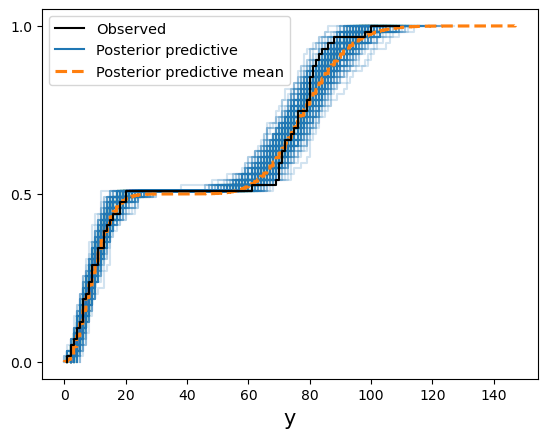

In [25]:
# Plot the ECDF vs the Posterior Predictive
az.plot_ppc(idata, kind = "cumulative", num_pp_samples=200)
plt.show()

Based on this plot, I would say that the data fit this model reasonable well, and O don't see any large deviations that we would not expect.

## Inference

In [38]:
# Flatten the means to create a matrix
flat_means = idata.posterior["means"] \
    .stack(sample = ("chain", "draw"),
           cell = ("texture", "tape")) \
    .transpose("sample", "cell") # Ensure that the dimensions are correct

# Check the Order of the Means in the matrix
flat_means.cell.values

array([('Flat', 'Frog'), ('Flat', '3M'), ('Flat', 'Standard'),
       ('Textured', 'Frog'), ('Textured', '3M'), ('Textured', 'Standard')],
      dtype=object)

In [39]:
# Create a Dataframe with the cell means for plotting
col_names = [i + ":" + j for i, j in flat_means.cell.values]

means_df = pd.DataFrame(flat_means, columns=col_names) \
    .melt(var_name="Treatment", value_name="mean")

means_df[['Texture', 'Tape']] = means_df["Treatment"] \
    .str \
    .extractall(r"([1-9a-zA-Z]+):([1-9a-zA-Z]+)") \
    .reset_index(drop=True)

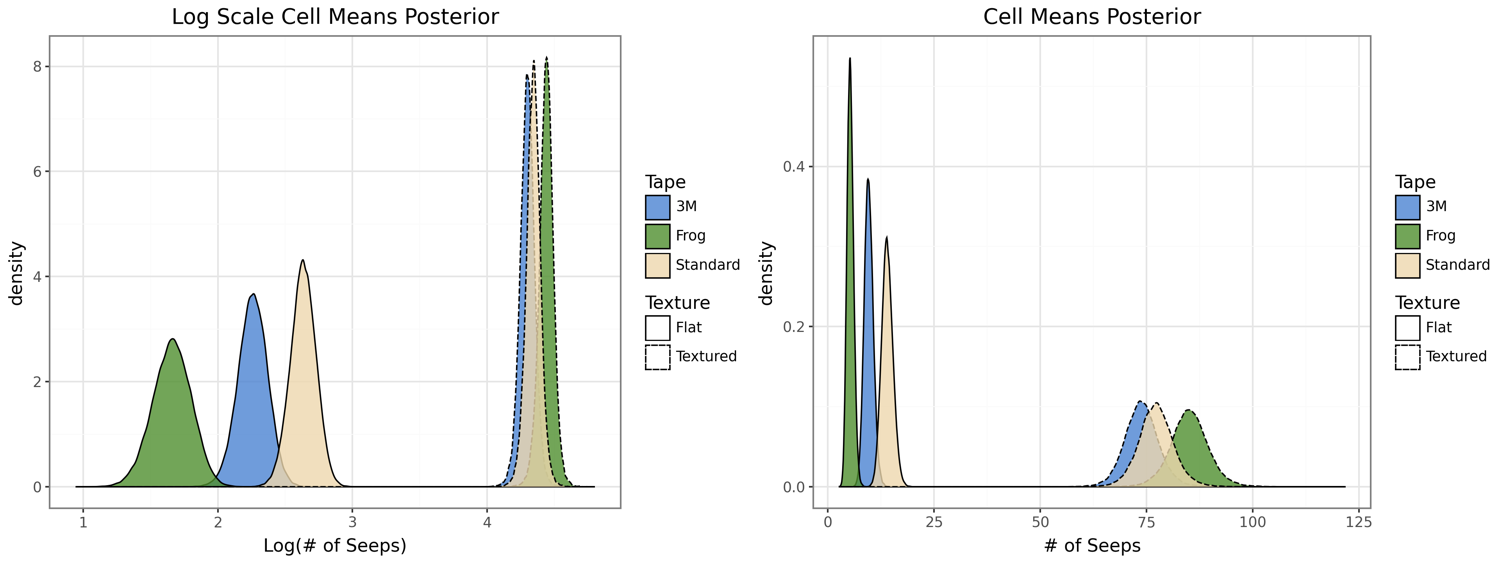

In [12]:
log_scale = ggplot(means_df) \
+ geom_density(aes(x = "mean", fill = "Tape", linetype = "Texture"),
               alpha = 0.8) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ labs(
    title = "Log Scale Cell Means Posterior",
    x = "Log(# of Seeps)"
)

original_scale = ggplot(means_df) \
+ geom_density(aes(x = "np.exp(mean)", fill = "Tape", linetype = "Texture"),
               alpha = 0.8) \
+ scale_fill_manual(values = ['#4b83d2','#4f8f2e',  '#EED8AE']) \
+ labs(
    title = "Cell Means Posterior",
    x = "# of Seeps"
)

grid = PGrid({"log" : log_scale,
              "orig" : original_scale})
grid.quilt("log + orig", size = (1500, 2000))

We can see from these cell means that there is clear separation between the estimated cell means for the flat surfaces, but they are further spread apart for the textured surfaces.

In [40]:
# Define Contrast Matrix for Main Effects and Interactions
Contrasts = np.array([[-0.5, 0.5, 0, -0.5, 0.5, 0], # Overall effect of Frog Tape over 3M (frog tape has x times less seeps than 3m)
                      [0, -0.5, 0.5, 0, -0.5, 0.5], # Overall effect of 3M tape over Standard (3M has x times less seeps than Standard)
                      [-1/3, -1/3, -1/3, 1/3, 1/3, 1/3], # Overall effect of texture (flat has x times less seeps than textured)
                      [1, -1, 0, -1, 1, 0],
                      [0, 1, -1, 0, -1, 1]]) # Interaction
c_dist = flat_means.values @ Contrasts.T

In [41]:
# Print Posterior Probability of an Interaction
print((c_dist[:,4] > 0).mean())
print((c_dist[:,3] > 0).mean())

0.010166666666666666
3.3333333333333335e-05


It appears that there is a high probability of an interaction between the variables, so we need to look at the effects individually for flat and for textured

In [42]:
# The Order of the means:
# ('Flat', 'Frog'), ('Flat', '3M'), ('Flat', 'Standard'), ('Textured', 'Frog'), ('Textured', '3M'), ('Textured', 'Standard')

# 3M - Frog: Flat
c0 = [-1, 1, 0, 0, 0, 0]

# Standard - 3M: Flat
c1 = [0, -1, 1, 0, 0, 0]

# 3M - Frog: Textured
c2 = [0, 0, 0, -1, 1, 0]

# Standard - 3M: Textured
c3 = [0, 0, 0, 0, -1, 1]

Contrasts = np.array([c0,c1,c2,c3])

# Compute Posterior Contrasts
c_dist = flat_means.values @ Contrasts.T

In [43]:
class geom_density_highlight(geom_density):
    # new method
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f"{self.region[0]} <= x <= {self.region[1]}"  # new line
        data = data.query(s).reset_index(drop=True)  # new line
        return data

### Is Frog Tape Better than 3M?

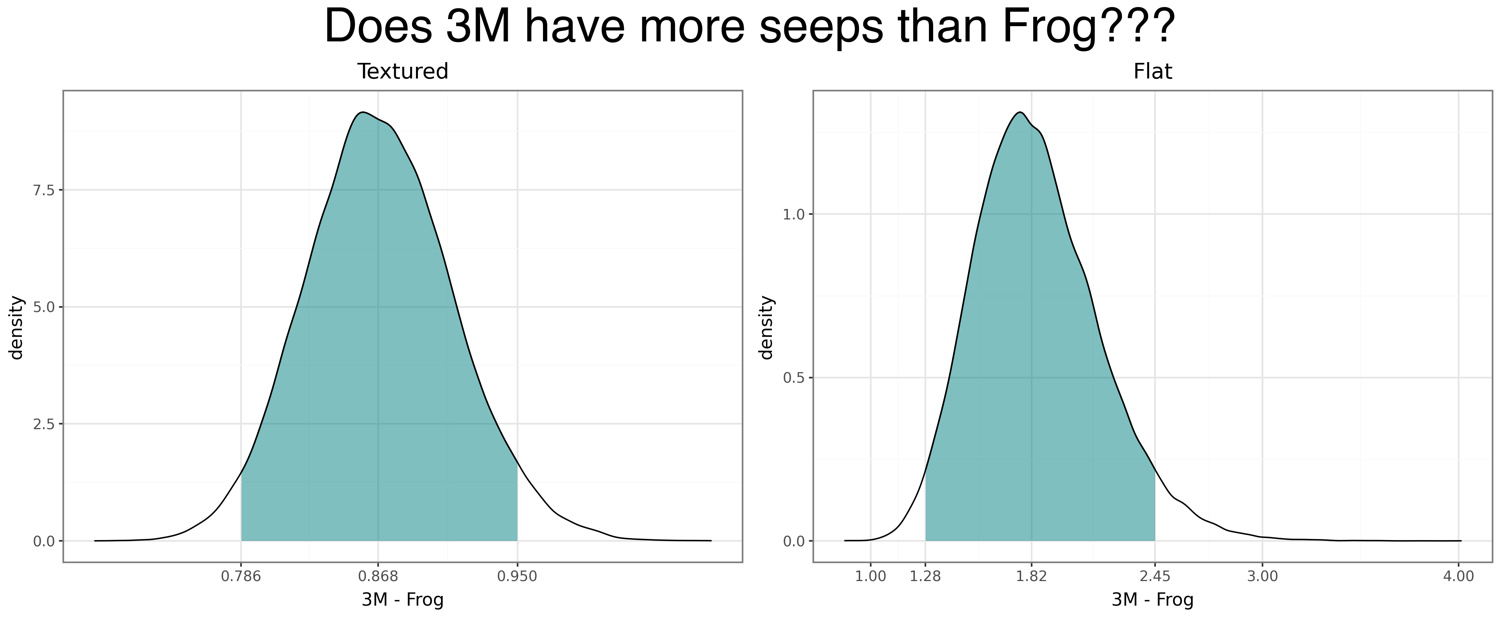

In [47]:
# Calculate HDI for Textured Surfaces
textured_3m_frog = np.exp(c_dist[:, 2])
hdi_textured_3m_frog = az.hdi(np.exp(c_dist[:,2]))
plot1 = ggplot(aes(x = "textured_3m_frog")) \
+ geom_density_highlight(region=hdi_textured_3m_frog,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Textured",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [0, hdi_textured_3m_frog[0], np.median(textured_3m_frog),hdi_textured_3m_frog[1], 1.5])

# Calculate HDI for Flat Surfaces
flat_3m_frog = np.exp(c_dist[:, 0])
hdi_flat_3m_frog = az.hdi(np.exp(c_dist[:,0]))
plot2 = ggplot(aes(x = "flat_3m_frog")) \
+ geom_density_highlight(region=hdi_flat_3m_frog,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Flat",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [1, hdi_flat_3m_frog[0], np.median(flat_3m_frog),hdi_flat_3m_frog[1], 3,4])
PGrid({"plot1" : plot1,
       "plot2" : plot2}).quilt("plot1 + plot2", title="Does 3M have more seeps than Frog???", size = (1500, 2000))

There is a 94% posterior probability given our data and prior knowledge that the mean number of seeps for 3M tape is 1.28 to 2.45 times the mean number of seeps for Frog tape for flat surfaces. 

For textured surfaces, we see the opposite, our 94% high density credible interval shows that the mean number of seeps for 3M tape is associated with a 5% to 21% decrease in the number of seeps compared to the Frog tape.

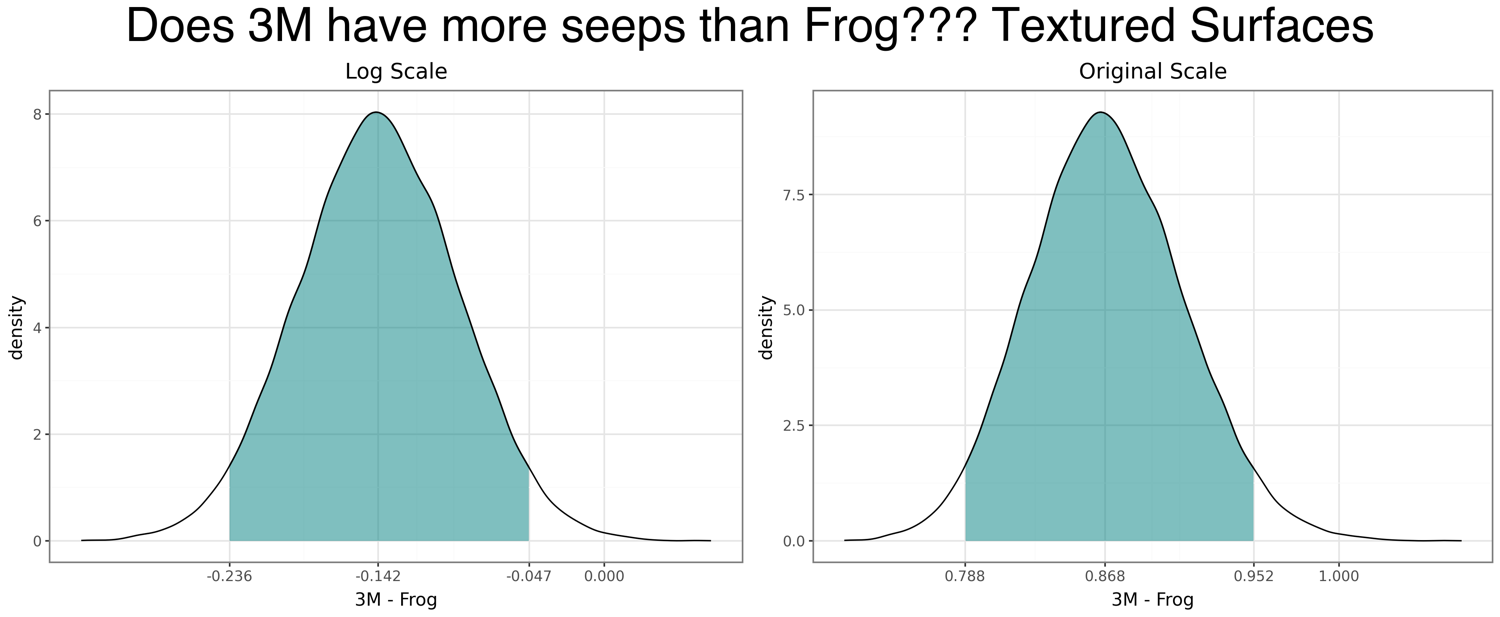

In [35]:
to_plot = c_dist[::10, 2]
orig_to_plot = np.exp(to_plot)
hdi_log = az.hdi(c_dist[:,2])
hdi_orig = az.hdi(np.exp(c_dist[:,2]))

plot1 = ggplot(aes(x = "to_plot")) \
+ geom_density_highlight(region=hdi_log,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Log Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [0, hdi_log[0], np.median(to_plot),hdi_log[1], 1.5])

plot2 = ggplot(aes(x = "orig_to_plot")) \
+ geom_density_highlight(region=hdi_orig,
                         fill = "teal",
                         alpha = 0.5) \
+ geom_density() \
+ labs(
    title = "Original Scale",
    x = "3M - Frog"
) \
+ scale_x_continuous(breaks = [1, hdi_orig[0], np.median(orig_to_plot),hdi_orig[1], 3,4])
PGrid({"plot1" : plot1,
       "plot2" : plot2}).quilt("plot1 + plot2", title="Does 3M have more seeps than Frog??? Textured Surfaces", size = (1500, 2000))

For the 